<img align="center" src="figures/course.png" width="800">

#                                    16720 (B) Neural Networks for Recognition - Assignment 3

     Instructor: Kris Kitani                       TAs: Qichen(Lead), Paritosh, Rawal, Yan, Zen, Wen-Hsuan

## Q7 PyTorch (40 points)

**Please include all the write up answers below to theory.ipynb. For the questions need code, you need to include the screenshot of code to theory.ipynb to get points.**

While you were able to derive manual back-propagation rules for sigmoid and fully-connected layers, wouldn't it be nice if someone did that for lots of useful primatives and made it fast and easy to use for general computation?  Meet [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation). Since we have high-dimensional inputs (images) and low-dimensional outputs (a scalar loss), it turns out **forward mode AD** is very efficient. Popular autodiff packages include [pytorch](https://pytorch.org/) (Facebook), [tensorflow](https://www.tensorflow.org/) (Google), [autograd](https://github.com/HIPS/autograd) (Boston-area academics). Autograd provides its own replacement for numpy operators and is a drop-in replacement for numpy, except you can ask for gradients now. The other two are able to act as shim layers for [cuDNN](https://developer.nvidia.com/cudnn), an implementation of auto-diff made by Nvidia for use on their GPUs. Since GPUs are able to perform large amounts of math much faster than CPUs, this makes the former two packages very popular for researchers who train large networks. Tensorflow asks you to build a computational graph using its API, and then is able to pass data through that graph. PyTorch builds a dynamic graph and allows you to mix autograd functions with normal python code much more smoothly, so it is currently more popular among CMU students. 

We will use [pytorch](https://pytorch.org/) as a framework. Many computer vision projects use neural networks as a basic building block, so familiarity with one of these frameworks is a good skill to develop. Here, we basically replicate and slightly expand our handwritten character recognition networks, but do it in PyTorch instead of doing it ourselves. Feel free to use any tutorial you like, but we like [the offical one](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) or [this tutorial](http://cs231n.stanford.edu/notebooks/pytorch_tutorial.ipynb) (in a jupyter notebook) or [these slides](http://cs231n.stanford.edu/slides/2018/cs231n_2018_lecture08.pdf (starting from number 35).

**For this section, you're free to implement these however you like. All of the tasks required here are fairly small and don't require a GPU if you use small networks. Including 7.2.**

### Q7.1 Train a neural network in PyTorch

#### Q7.1.1 (10 Points Code+WriteUp)
 
Re-write and re-train your fully-connected network on NIST36 in PyTorch. Plot training accuracy and loss over time.

<font color="red">**Please include the write up answer and the screenshot of code to theory.ipynb**</font>

In [ ]:
%run q2.ipynb

Train Acc: 0.1612962962962963  Train Loss: 3.2487123432865848
Val Acc: 0.35638888888888887  Val Loss: 2.6581881046295166
Train Acc: 0.48203703703703704  Train Loss: 2.1423881400073017
Val Acc: 0.5555555555555556  Val Loss: 1.780210018157959
Train Acc: 0.5955555555555555  Train Loss: 1.5651918786543386
Val Acc: 0.6138888888888889  Val Loss: 1.4495402574539185
Train Acc: 0.6423148148148148  Train Loss: 1.3245144611817818
Val Acc: 0.6430555555555556  Val Loss: 1.3001614809036255
Train Acc: 0.6704629629629629  Train Loss: 1.193071419707051
Val Acc: 0.6630555555555555  Val Loss: 1.214043140411377
Train Acc: 0.6930555555555555  Train Loss: 1.1034143087157497
Val Acc: 0.6786111111111112  Val Loss: 1.1517620086669922
Train Acc: 0.7129629629629629  Train Loss: 1.0346704416363328
Val Acc: 0.6902777777777778  Val Loss: 1.1060752868652344
Train Acc: 0.7284259259259259  Train Loss: 0.9783114214296694
Val Acc: 0.6980555555555555  Val Loss: 1.0730485916137695
Train Acc: 0.741574074074074  Train Loss:

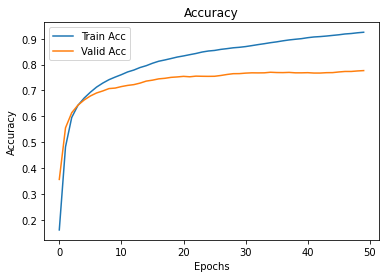

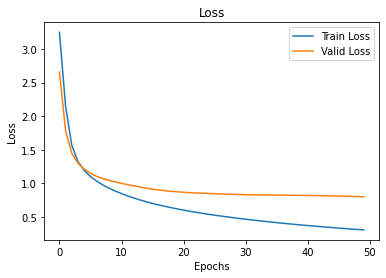

In [4]:
import numpy as np
import scipy.io

#from ipynb.fs.defs.q2 import *
import import_ipynb
from q2 import *

import torch
import torchvision.datasets
import matplotlib.pyplot as plt

# YOUR CODE HERE

train_data = scipy.io.loadmat('data/nist36_train.mat')
valid_data = scipy.io.loadmat('data/nist36_valid.mat')
test_data = scipy.io.loadmat('data/nist36_test.mat')

train_x, train_y = torch.from_numpy(train_data['train_data']), torch.from_numpy(train_data['train_labels'])
valid_x, valid_y = torch.from_numpy(valid_data['valid_data']), torch.from_numpy(valid_data['valid_labels'])
test_x, test_y = torch.from_numpy(test_data['test_data']), torch.from_numpy(test_data['test_labels'])

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(train_x.shape[1], 64)
        self.fc2 = torch.nn.Linear(64, train_y.shape[1])
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x

model = Net()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

train_batches = get_random_batches(train_x, train_y, 16)

max_iters = 50
train_loss_mem = []
train_acc_mem = []
valid_loss_mem = []
valid_acc_mem = []

for iters in range(max_iters):
    for phase in ['train', 'valid']:
        total_loss = 0
        total = 0
        correct = 0

        if phase == 'train':
            batches = train_batches
            model.train()
        else:
            batches = [(valid_x, valid_y)]
            model.eval()

        for xb, yb in batches:
            inputs, labels = xb.float(), np.argmax(yb.float(), axis=1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            if phase == 'train':
                loss.backward()
                optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            total_loss += loss.item() * inputs.size(0)

        if phase == 'train':
            print("Train Acc:", correct/total, " Train Loss:", total_loss/total)
            train_acc_mem.append(correct/total)
            train_loss_mem.append(total_loss/total)
        else:
            print("Valid Acc:", correct/total, " Valid Loss:", total_loss/total)
            valid_acc_mem.append(correct/total)
            valid_loss_mem.append(total_loss/total)

print('Validation accuracy: ', correct/total)

plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_acc_mem, label='Train Acc')
plt.plot(valid_acc_mem, label='Valid Acc')
plt.legend()
plt.show()

plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_loss_mem, label='Train Loss')
plt.plot(valid_loss_mem, label='Valid Loss')
plt.legend()
plt.show()

# raise NotImplementedError()

#### Q7.1.2 (3 Points Code+WriteUp)
 
Train a convolutional neural network with PyTorch on MNIST. Plot training accuracy and loss over time.

<font color="red">**Please include the write up answer and the screenshot of code to theory.ipynb**</font>

device = cpu
Get dataset
dataset size train, test
torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
Train Acc: 0.8801833333333333  Train Loss: 0.4165119975646337
Val Acc: 0.9435  Val Loss: 0.1925320189282298
Train Acc: 0.95025  Train Loss: 0.1650239668806394
Val Acc: 0.9624  Val Loss: 0.12270414385832847
Train Acc: 0.9663833333333334  Train Loss: 0.11119486284131805
Val Acc: 0.9738  Val Loss: 0.08565921450722963
Train Acc: 0.9748166666666667  Train Loss: 0.08335384294885055
Val Acc: 0.9789  Val Loss: 0.0672054630285129
Train Acc: 0.9793166666666666  Train Loss: 0.06778630882805835
Val Acc: 0.9808  Val Loss: 0.059755456158705055
Train Acc: 0.9827  Train Loss: 0.056582724934203237
Val Acc: 0.9826  Val Loss: 0.05215143719068729
Train Acc: 0.985  Train Loss: 0.048701556156532995
Val Acc: 0.9849  Val Loss: 0.04971219778545201
Train Acc: 0.9875  Train Loss: 0.04234443910885214
Val Acc: 0.9813  Val Loss: 0.05611748950025067
Train Acc: 0.9886333333333334  Train Loss: 0.03719977457579225


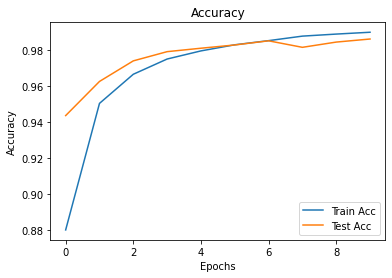

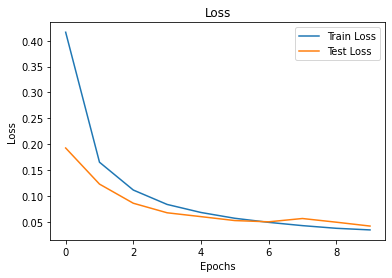

In [6]:
import numpy as np
import scipy.io
import torch
import torchvision
from torch import nn, optim
import torch.nn.functional as F  # a lower level (compared to torch.nn) interface
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from time import time
import copy

# Use GPU if available, otherwise stick with cpu
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device("cuda" if use_cuda else "cpu")
print("device = {}".format(device))

print("Get dataset")
mnist_train = MNIST(root="data", train=True, download=True, transform=transforms.ToTensor())
trainset_loader = DataLoader(mnist_train, batch_size=16, shuffle=True, num_workers=1)

mnist_test = MNIST(root="data", train=False, download=True, transform=transforms.ToTensor())
testset_loader = DataLoader(mnist_test, batch_size=16, shuffle=True, num_workers=1)

print("dataset size train, test")
print(trainset_loader.dataset.data.shape)
print(testset_loader.dataset.data.shape)

# YOUR CODE HERE

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Conv2d(1, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*12*12, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = x.view(-1, 16*12*12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

Best_state = copy.deepcopy(model.state_dict())
best_acc = 0

max_iters = 10
train_loss_mem = []
train_acc_mem = []
valid_loss_mem = []
valid_acc_mem = []

for itr in range(max_iters):
    for phase in ['train', 'valid']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        total_loss = 0
        total = 0
        total_cor = 0

        if phase == 'train':
            dataset_loader = trainset_loader
        else:
            dataset_loader = testset_loader

        for i, data in enumerate(dataset_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            if phase == 'train':
                loss.backward()
                optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            total_cor += (predicted == labels).sum().item()
            total_loss += loss.item() * inputs.size(0)

        if phase == 'train':
            print("Train Acc:", total_cor/total, " Train Loss:", total_loss/total)
            train_acc_mem.append(total_cor/total)
            train_loss_mem.append(total_loss/total)
        else:
            acc = total_cor/total
            if acc > best_acc:
                best_acc = acc
                best_model_state = copy.deepcopy(model.state_dict())

            print("Valid Acc:", total_cor/total, " Valid Loss:", total_loss/total)
            valid_acc_mem.append(total_cor/total)
            valid_loss_mem.append(total_loss/total)

print('Testing accuracy: ',best_acc)

plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_acc_mem, label='Train Acc')
plt.plot(valid_acc_mem, label='Test Acc')
plt.legend()
plt.show()

plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_loss_mem, label='Train Loss')
plt.plot(valid_loss_mem, label='Test Loss')
plt.legend()
plt.show()

# raise NotImplementedError()

#### Q7.1.3 (2 Points Code+WriteUp)
 
Train a convolutional neural network with PyTorch on the included NIST36 dataset. Plot training accuracy and loss over time.

<font color="red">**Please include the write up answer and the screenshot of code to theory.ipynb**</font>

device = cpu
Get dataset
Train Acc: 0.4058333333333333  Train Loss: 2.1180080493732736
Val Acc: 0.7563888888888889  Val Loss: 0.8006430864334106
Train Acc: 0.815462962962963  Train Loss: 0.603802659953082
Val Acc: 0.8441666666666666  Val Loss: 0.48892056941986084
Train Acc: 0.8681481481481481  Train Loss: 0.43229152639155033
Val Acc: 0.8652777777777778  Val Loss: 0.42975950241088867
Train Acc: 0.8866666666666667  Train Loss: 0.3582358667999506
Val Acc: 0.86  Val Loss: 0.4416966438293457
Train Acc: 0.8975925925925926  Train Loss: 0.30898824002041864
Val Acc: 0.8602777777777778  Val Loss: 0.43424147367477417
Train Acc: 0.9080555555555555  Train Loss: 0.27562011756416827
Val Acc: 0.8608333333333333  Val Loss: 0.4940551221370697
Train Acc: 0.9196296296296296  Train Loss: 0.2434512458389832
Val Acc: 0.865  Val Loss: 0.4860485792160034
Train Acc: 0.9274074074074075  Train Loss: 0.2174555358176844
Val Acc: 0.8694444444444445  Val Loss: 0.48374131321907043
Train Acc: 0.9287962962962963  Train 

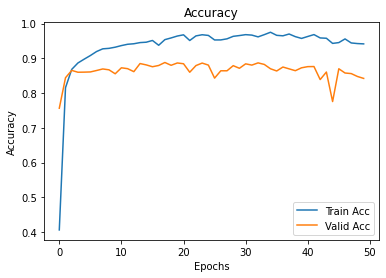

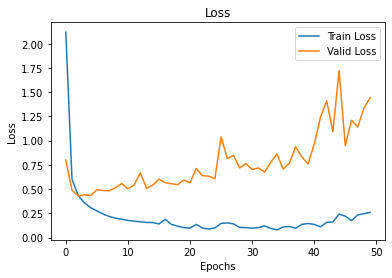

In [7]:
import numpy as np
import scipy.io
import torch
from torch import nn, optim
import torch.nn.functional as F  # a lower level (compared to torch.nn) interface
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from time import time
import matplotlib.pyplot as plt

# Use GPU if available, otherwise stick with cpu
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device("cuda" if use_cuda else "cpu")
print("device = {}".format(device))

print("Get dataset")
train_data = scipy.io.loadmat('data/nist36_train.mat')
valid_data = scipy.io.loadmat('data/nist36_valid.mat')

# train_x, train_y = train_data['train_data'].astype(np.float32), train_data['train_labels'].astype(np.int)
# valid_x, valid_y = valid_data['valid_data'].astype(np.float32), valid_data['valid_labels'].astype(np.int)

# To do

train_x, train_y = torch.from_numpy(train_data['train_data']), torch.from_numpy(train_data['train_labels'])
valid_x, valid_y = torch.from_numpy(valid_data['valid_data']), torch.from_numpy(valid_data['valid_labels'])

# YOUR CODE HERE

train_batches = get_random_batches(train_x, train_y, 16)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 64)
        self.fc2 = nn.Linear(64, train_y.shape[1])

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

max_iters = 50
train_loss_mem = []
train_acc_mem = []
valid_loss_mem = []
valid_acc_mem = []

for itr in range(max_iters):
    for phase in ['train', 'valid']:
        running_loss = 0.0
        total = 0
        correct = 0

        if phase == 'train':
            batches = train_batches
            model.train()
        else:
            batches = [(valid_x, valid_y)]
            model.eval()

        for xb, yb in batches:
            inputs, labels = xb.float(), np.argmax(yb.float(), axis=1)
            inputs = inputs.view(inputs.shape[0], 1, 32, 32)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            if phase == 'train':
                loss.backward()
                optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item() * inputs.size(0)

        if phase == 'train':
            print("Train Acc:", correct / total, " Train Loss:", running_loss / total)
            train_acc_mem.append(correct / total)
            train_loss_mem.append(running_loss / total)
        else:
            print("Valid Acc:", correct / total, " Valid Loss:", running_loss / total)
            valid_acc_mem.append(correct / total)
            valid_loss_mem.append(running_loss / total)

print('validate accuracy: ',best_acc)

plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_acc_mem, label='Train Acc')
plt.plot(valid_acc_mem, label='Valid Acc')
plt.legend()
plt.show()

plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_loss_mem, label='Train Loss')
plt.plot(valid_loss_mem, label='Valid Loss')
plt.legend()
plt.show()

# raise NotImplementedError()

#### Q7.1.4 (15 Points Code+WriteUp)
 
Train a convolutional neural network with PyTorch on the EMNIST Balanced dataset  (available in *torchvision.datasets*, use *balanced* split) and evaluate it on the findLetters bounded boxes from the images folder. Find the accuracy on these bounded boxes.

<font color="red">**Please include the write up answer and the screenshot of code to theory.ipynb**</font>

importing Jupyter notebook from q4.ipynb


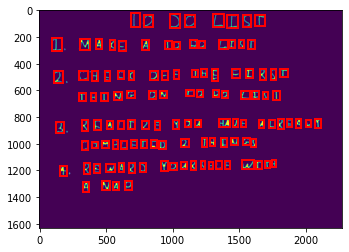

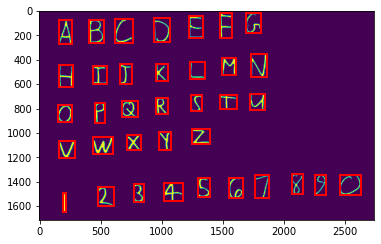

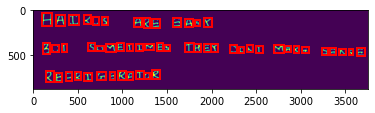

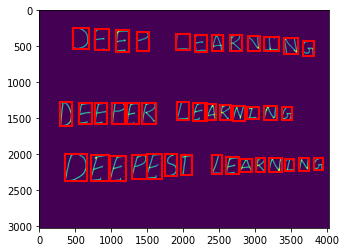

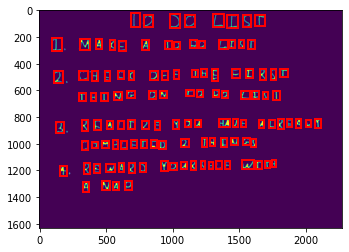

01_list.jpg
7QDOLIQT
INAREATDDDLIQ8
2LH2ERQEE8HER8RQ8
8H8NGQNTQDQEIQ7
3R2AE82EX0UM6EA6R6ADX
EQMP6886DZ1H8NGQ
5R8WARDX0URQE6EWD8B
ANAR



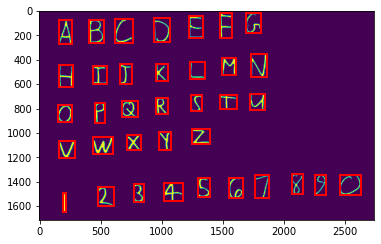

02_letters.jpg
AB6DE8G
HI8RLRN
08QRQTU
VWXXZ
8Z3QS6383Q



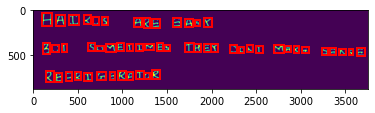

03_haiku.jpg
HAIR6QAREGASX
BQ7SQMETIMESTREXDDNTMAKESENQE
RBFRIGERA8QR



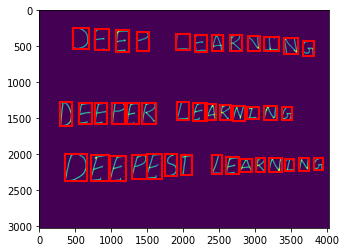

04_deep.jpg
DEE8LEARBING
DEEBERLBARNING
DEERES8LEARRING



In [8]:
import import_ipynb
from q4 import *

In [10]:
import numpy as np
import scipy.io
import torch
from torch import nn, optim
import torchvision
import torch.nn.functional as F  # a lower level (compared to torch.nn) interface
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import EMNIST
import torchvision.transforms as transforms
from time import time
import os
import skimage
import matplotlib
# from q4.ipynb import *

# Use GPU if available, otherwise stick with cpu
use_cuda = torch.cuda.is_available()
torch.manual_seed(123)
device = torch.device("cuda" if use_cuda else "cpu")
print("device = {}".format(device))

print("Get dataset")

EMNIST.url = 'http://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip'
# Reference for transform function
# https://stackoverflow.com/a/54513835
transform=torchvision.transforms.Compose([
    lambda img: torchvision.transforms.functional.rotate(img, -90),
    lambda img: torchvision.transforms.functional.hflip(img),
    torchvision.transforms.ToTensor()
])
emnist_train = EMNIST(root="data", split='balanced', train=True, download=True, transform=transform)
trainset_loader = DataLoader(emnist_train, batch_size=20, shuffle=True, num_workers=1)

emnist_test = EMNIST(root="data", split='balanced', train=False, download=True, transform=transform)
testset_loader = DataLoader(emnist_test, batch_size=20, shuffle=True, num_workers=1)

# Ref: https://github.com/gaurav0651/emnist/blob/master/train_emnist.ipynb
label_map = np.array(['0','1','2','3','4','5','6','7','8','9',
       'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
       'a','b','d','e','f','g','h','n','q','r','t'])

print(trainset_loader.dataset.data.shape)
print(trainset_loader.dataset.data.shape)
print(testset_loader.dataset.data.shape)

# YOUR CODE HERE

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Conv2d(1, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 47)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = x.view(-1, 16 * 12 * 12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

max_iters = 5

for itr in range(max_iters):
    loss_sum = 0
    for i, data in enumerate(trainset_loader):
        inputs, labels = data

        batch_imgs = inputs[:, 0, :, :].detach().numpy()
        batch_imgs = batch_imgs.reshape(batch_imgs.shape[0], -1)
        batch_imgs = -(batch_imgs - np.mean(batch_imgs, axis=1).reshape(-1, 1))/np.std(batch_imgs, axis=1).reshape(-1, 1)
        inputs = torch.from_numpy(batch_imgs.reshape(batch_imgs.shape[0], 1, 28, 28))
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        loss_sum +=loss.item() * inputs.shape[0]

    if itr % 1 == 0:
        print("valid itr: {:02d} \t loss: {:.2f}".format(itr, loss_sum/len(trainset_loader.dataset)))

print('Finished Training')
torch.save(model.state_dict(), "q7_1_4.pth")

# raise NotImplementedError()

device = cpu
Get dataset
torch.Size([112800, 28, 28])
torch.Size([112800, 28, 28])
torch.Size([18800, 28, 28])
valid itr: 00 	 loss: 0.72
valid itr: 01 	 loss: 0.43
valid itr: 02 	 loss: 0.37
valid itr: 03 	 loss: 0.34
valid itr: 04 	 loss: 0.30
Finished Training


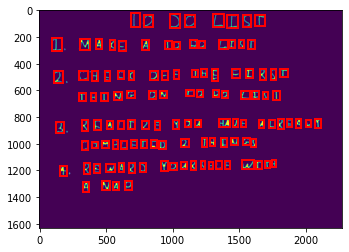

01_list.jpg
rOOO7HWr
4EtTMtrOOO7YNr
UnInnTOTT4InTYnnr
7IHSQOSrOOOgMNf
WrnKTnnraDZZZn27aMeOX
OOET7MrrOYFZHSQN
4Ir3eaOXO2rnn7T3HrI
eStO
Accuracy: 0.09649122807017543



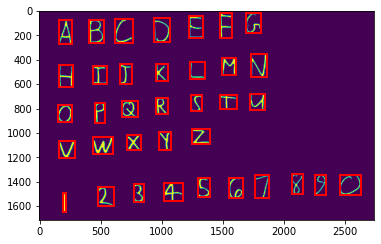

02_letters.jpg
tOODMTQ
IHPT7ES
OrQrNtZ
D3XXn
tgW4nOCnWQ
Accuracy: 0.1388888888888889



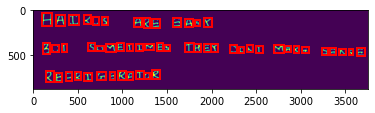

03_haiku.jpg
ICHXDNC0MMCNr
ODrNOEMrHEMNrZM2OOSrECTMNMSN9
TnTOHQMaCFOa
Accuracy: 0.05555555555555555



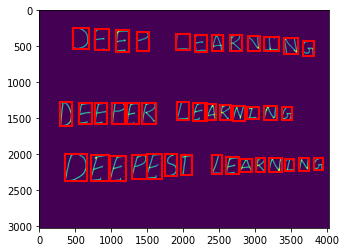

04_deep.jpg
OMTr7MtnSHIQ
GrnLrJnngTSrSQ
OrnKrNfGRKJSHSR
Accuracy: 0.0



In [11]:
model.load_state_dict(torch.load("q7_1_4.pth"))
model.eval()

for img in os.listdir('images'):
    im1 = skimage.img_as_float(skimage.io.imread(os.path.join('images', img)))
    bboxes, bw = findLetters(im1)

    plt.imshow(bw)
    for bbox in bboxes:
        minr, minc, maxr, maxc = bbox

        rect = matplotlib.patches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                            fill=False, edgecolor='red', linewidth=2)
        plt.gca().add_patch(rect)
    plt.show()

    bboxes = sorted(bboxes, key=lambda x: x[0])
    prev_y1, prev_x1, prev_y2, prev_x2 = bboxes[0]
    rows = [[bboxes[0]]]
    for i in range(1, len(bboxes)):
        y1, x1, y2, x2 = bboxes[i]
        if y1 > prev_y2:
            rows.append([bboxes[i]])
        else:
            rows[-1].append(bboxes[i])

        prev_y1, prev_x1, prev_y2, prev_x2 = y1, x1, y2, x2

    for i in range(0, len(rows)):
        rows[i] = sorted(rows[i], key=lambda x: x[1])

    crop_rows = []
    for row in rows:
        crops = []
        for bbox in row:
            y1, x1, y2, x2 = bbox
            side = max(y2-y1, x2-x1)
            center_y, center_x = (y2+y1) / 2, (x2+x1) / 2
            crop = bw[int(center_y-side/2): int(center_y+side/2), int(center_x-side/2):int(center_x+side/2)] * (-1.)
            crop = skimage.transform.resize(crop, (20, 20))
            crop = np.pad(crop, ((4, 4), (4, 4)), constant_values=crop.max())
            crop = crop.T.flatten()
            crops.append(crop)

        crops = np.array(crops)
        crops = (crops - np.mean(crops, axis=1).reshape(-1, 1)) / np.std(crops, axis=1).reshape(-1, 1)
        crop_rows.append(crops)

    print(img)

    correct = None
    if img == '02_letters.jpg':
        correct = ["ABCDEFG", "HIJKLMN", "OPQRSTU", "VWXYZ", "1234567890"]
    elif img == '04_deep.jpg':
        correct = ["DEEPLEARNING", "DEEPERLEARNING", "DEEPESTLEARNING"]
    elif img == '01_list.jpg':
        correct = ["TODOLIST", "1MAKEATODOLIST", "2CHECKOFFTHEFIRST", "THINGONTODOLIST", "3REALIZEYOUHVEALREADY",
                   "COMPLETED2THINGS", "4REWARDYOURSELFWITH", "ANAP"]
    elif img == '03_haiku.jpg':
        correct = ["HAIKUSAREEASY", "BUTSOMETIMESTHEYDONTMAKESENSE", "REFRIGERATOR"]

    count = 0
    total = 0
    for idx, crops in enumerate(crop_rows):
        crops = crops.reshape(-1, 1, 28, 28)
        outputs = model(torch.from_numpy(crops).float())
        _, predicted = torch.max(outputs.data, 1)
        output = label_map[predicted]
        output = ''.join(output)
        print(output)

        total += len(output)
        if correct is not None:
            for i in range(len(output)):
                if output[i] == correct[idx][i]:
                    count += 1

    print("Accuracy:", count / total)
    print()

### Q7.2 Fine Tuning

#### Q7.2.1 (10 Points Code+WriteUp)
 
Fine-tune a single layer classifier using pytorch on the [flowers 17](http://www.robots.ox.ac.uk/~vgg/data/flowers/17/index.html) (or [flowers 102](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html)!) dataset using [squeezenet1\_1](https://pytorch.org/docs/stable/torchvision/models.html), as well as an architecture you've designed yourself (*3 conv layers, followed 2 fc layers, it's standard [slide 6](http://cs231n.stanford.edu/slides/2018/cs231n_2018_lecture09.pdf)*) and trained from scratch. How do they compare? 
    
We include a script in `scripts/` to fetch the flowers dataset and extract it in a way that [PyTorch ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) can consume it, see [an example](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#afterword-torchvision), from **data/oxford-flowers17**. You should look at how SqueezeNet is [defined](https://github.com/pytorch/vision/blob/master/torchvision/models/squeezenet.py), and just replace the classifier layer. There exists a pretty good example for [fine-tuning](https://gist.github.com/jcjohnson/6e41e8512c17eae5da50aebef3378a4c) in PyTorch.

<font color="red">**Please include the write up answer and the screenshot of code to theory.ipynb**</font>

In [12]:
# Code for fine-tune squeezenet1_1
# YOUR CODE HERE

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

# from nn import *
# from q4 import *

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches
import torch
from torchvision import transforms, datasets
import torchvision
import copy


train_transform = transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
val_transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

flower17_trainset = datasets.ImageFolder(root='data/oxford-flowers17/train', transform=train_transform)
train_loader = torch.utils.data.DataLoader(flower17_trainset, batch_size=8, shuffle=True, num_workers=4)
flower17_valset = datasets.ImageFolder(root='data/oxford-flowers17/val', transform=val_transform)
val_loader = torch.utils.data.DataLoader(flower17_valset, batch_size=8, shuffle=False, num_workers=4)
flower17_testset = datasets.ImageFolder(root='data/oxford-flowers17/test', transform=val_transform)
test_loader = torch.utils.data.DataLoader(flower17_testset, batch_size=8, shuffle=False, num_workers=4)


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 24 * 24, 512)
        self.fc2 = nn.Linear(512, 17)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 32 * 24 * 24)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


def main():
    model = torchvision.models.squeezenet1_1(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier[1] = nn.Conv2d(512, 17, kernel_size=(1, 1), stride=(1, 1))
    model.num_classes = 17

    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad:
            params_to_update.append(param)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

    best_model_state = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    max_iters = 10
    train_acc_history = []
    train_loss_history = []
    val_acc_history = []
    val_loss_history = []

    for iter in range(max_iters):
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.
            running_total = 0.
            running_correct = 0.

            if phase == 'train':
                dataset_loader = train_loader
            else:
                dataset_loader = val_loader

            for i, data in enumerate(dataset_loader, 0):
                inputs, labels = data

                optimizer.zero_grad()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                _, predicted = torch.max(outputs.data, 1)
                running_total += labels.size(0)
                running_correct += (predicted == labels).sum().item()
                running_loss += loss.item() * inputs.size(0)

            if phase == 'train':
                print("Train Acc:", running_correct / running_total, " Train Loss:", running_loss / running_total)
                train_acc_history.append(running_correct / running_total)
                train_loss_history.append(running_loss / running_total)
            else:
                acc = running_correct / running_total
                if acc > best_acc:
                    best_acc = acc
                    best_model_state = copy.deepcopy(model.state_dict())

                print("Valid Acc:", running_correct / running_total, " Valid Loss:", running_loss / running_total)
                val_acc_history.append(running_correct / running_total)
                val_loss_history.append(running_loss / running_total)

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(train_acc_history, label='Training Acc')
    plt.plot(val_acc_history, label='Val Acc')
    plt.legend()
    plt.show()

    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(train_loss_history, label='Training Loss')
    plt.plot(val_loss_history, label='Val Loss')
    plt.legend()
    plt.show()

    torch.save(best_model_state, "q7_2_fine_tuned.pth")
    model.load_state_dict(torch.load("q7_2_fine_tuned.pth"))

    model.eval()
    total = 0
    correct = 0
    for i, data in enumerate(test_loader, 0):
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print()
    print("Test Accuracy:", correct / total)

# raise NotImplementedError()

In [ ]:
# Code for fine-tune the network you designed
# YOUR CODE HERE



# raise NotImplementedError()